# Document Clustering and Topic Modeling

In this project, I use unsupervised learning model to cluster unlabeled documents into different groups, visualize the results.

In [126]:
import sqlite3
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import nltk
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

## 1. Load Data

In [127]:
db_name = 'customer_review_analysis.db'

query = """select name, rating, comment, timestamp_
            from reviews r 
            join users u 
            on r.id = u.id
        """

In [128]:
def connect_db(db_file):
    try:
        conn = sqlite3.connect(os.path.join(os.getcwd(), db_file))
        return conn
    except Exception as e:
        print (e)
    return None

In [129]:
# Read in the data from sqlite db
df = pd.read_sql(query, connect_db(db_name))
df.head()

,Name,Rating,Comment,Timestamp_
0,Krystof,5,"Great prices and customer service, shipping pr...","Friday, October 19, 2018 - 7:45:41 PM"
1,JACK,5,easy to find parts,"Friday, October 19, 2018 - 7:45:37 PM"
2,George,5,Excellent. The BEST in the business.,"Friday, October 19, 2018 - 7:35:03 PM"
3,jay,5,Just my latest order from B&H always satisfied...,"Friday, October 19, 2018 - 7:26:05 PM"
4,Chuck,5,"Easy, quick and great website. Found everythin...","Friday, October 19, 2018 - 6:46:44 PM"


### 1.1 Reviews by Month

In [130]:
from pprint import pprint
from collections import OrderedDict

# Monthly number of reviews for year 2018 so far
def monthly_count():
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthly_reviews = OrderedDict()
    for month in months:
        counts = df[df.Timestamp_.str.contains('.*?{}\s+\d+,\s+2018.*?'.format(month), case=False)].shape[0]
        monthly_reviews[month] = counts
    return monthly_reviews

ret = monthly_count()
pprint (ret)

OrderedDict([('January', 2073),
             ('February', 2040),
             ('March', 1943),
             ('April', 1797),
             ('May', 2199),
             ('June', 2140),
             ('July', 2136),
             ('August', 1960),
             ('September', 908),
             ('October', 920),
             ('November', 0),
             ('December', 0)])


## 2. Tokenization and Stemming

In [131]:
# Import English Stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [132]:
# Listify comments from dataframe
comments = df.Comment.tolist()
comments[:5]

['Great prices and customer service, shipping prices are either free or priced fairly.',
 'easy to find parts',
 'Excellent. The BEST in the business.',
 'Just my latest order from B&H always satisfied with products and service !',
 'Easy, quick and great website. Found everything I needed fast.']

In [133]:
len(comments)

19880

In [134]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization(text):
    """tokenize sentences and words; filter out tokens not containing letters"""
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word not in stopwords:
                tokens.append(word)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def tokenization_and_stemming(text):
    """tokenize and stem sentences and words"""
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [135]:
# Use defined functions to tokenize and create stemmed comments
comments_stemmed = []
comments_tokenized = []

for c in comments:    
    token_stem_res = tokenization_and_stemming(c)
    comments_stemmed.extend(token_stem_res)
    
    tokenized_res = tokenization(c)
    comments_tokenized.extend(tokenized_res)

In [136]:
# Create dictionary to store stems and orginal words
stem_token_mapper = {comments_stemmed[i]:comments_tokenized[i] for i in range(len(comments_stemmed))}

In [137]:
len(stem_token_mapper)

6741

## 3. Features with TF-IDF

In [138]:
# Define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

# Fit the vectorizer to comments
tfidf_matrix = tfidf_model.fit_transform(comments)

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " comments and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 19880 comments and 7 terms.


In [139]:
tf_selected_words = tfidf_model.get_feature_names()
tf_selected_words

['alway', 'b', 'easi', 'great', 'h', 'price', 'servic']

## 4. Calculate Document Similarity

In [140]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print (cos_matrix)

[[1.         0.         0.         ... 0.28129143 0.68354226 0.18743241]
 [0.         1.         0.         ... 0.         0.60546603 0.74565859]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.28129143 0.         0.         ... 1.         0.54105068 0.66632819]
 [0.68354226 0.60546603 0.         ... 0.54105068 1.         0.81198827]
 [0.18743241 0.74565859 0.         ... 0.66632819 0.81198827 1.        ]]


The higher the value, the similar the documents. 1 on the diagonal represents document with itself. 

## 5. K-Means Clustering

### 5.1 Train and analyze result

In [141]:
# Train k-means based on tfidf matrix
from sklearn.cluster import KMeans

num_clusters = 5 # change the number to have different numbers of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [142]:
# Append cluster column to initial dataframe
df['cluster'] = pd.Series(clusters).values
df.head()

,Name,Rating,Comment,Timestamp_,cluster
0,Krystof,5,"Great prices and customer service, shipping pr...","Friday, October 19, 2018 - 7:45:41 PM",0
1,JACK,5,easy to find parts,"Friday, October 19, 2018 - 7:45:37 PM",2
2,George,5,Excellent. The BEST in the business.,"Friday, October 19, 2018 - 7:35:03 PM",0
3,jay,5,Just my latest order from B&H always satisfied...,"Friday, October 19, 2018 - 7:26:05 PM",1
4,Chuck,5,"Easy, quick and great website. Found everythin...","Friday, October 19, 2018 - 6:46:44 PM",2


In [143]:
df['cluster'].value_counts().to_frame()

,cluster
0,6144
1,4815
2,3279
3,3102
4,2540


Cluster 2 has the largest number of comments based on the algorithm.

### 5.2 Present cluster keywords and visualize clusters

In [144]:
# km.cluster_centers_ denotes the importances of each items in centroid.
# We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :]:
        Cluster_keywords_summary[i].append(stem_token_mapper[tf_selected_words[ind]])

print ("<Document clustering keywords by K-means>")
Cluster_keywords_summary

<Document clustering keywords by K-means>


{0: ['service', 'prices', 'Always', 'Easy', 'B', 'H', 'Great'],
 1: ['B', 'H', 'Always', 'service', 'prices', 'Great', 'Easy'],
 2: ['Easy', 'Great', 'prices', 'Always', 'service', 'B', 'H'],
 3: ['Great', 'service', 'prices', 'Always', 'B', 'H', 'Easy'],
 4: ['Always', 'Great', 'service', 'prices', 'B', 'H', 'Easy']}

In [145]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

# Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# Set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

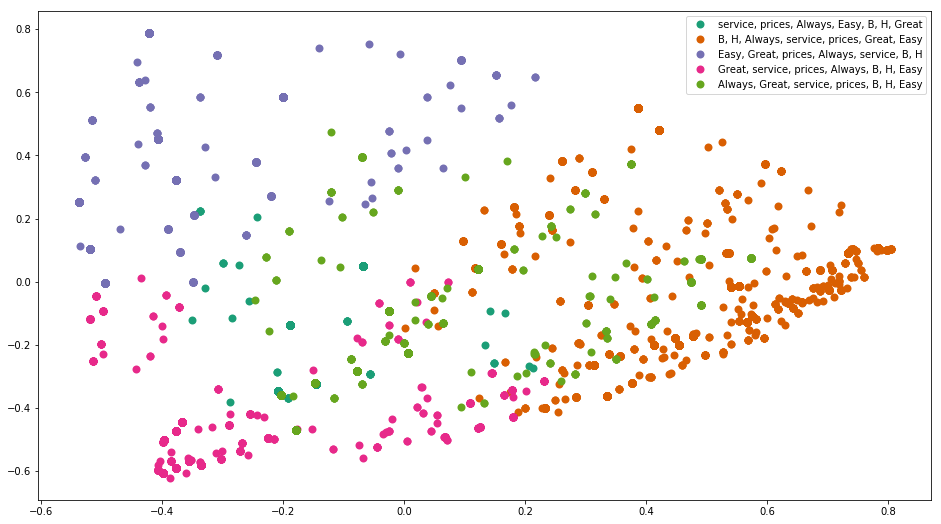

In [146]:
# Create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby(clusters)

# Set up plot
fig, ax = plt.subplots(figsize=(16, 9))

# Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc='best')  # Show legend with only 1 point

plt.show()

It appears that five clusters have similar keywords based on the analysis. There are also overlaps in some clusters. We can try different number of clusters using k-means, or try different algorithms to see if that will increase our result.